In [1]:
import sys
sys.path.append(os.path.abspath(os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), os.pardir)))
import _Data.PredictionDataBase.DBFunctions as db
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import corr_functions as cfnc

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [25]:
df = db.GetDAPrices().join(db.GetLoad()).join(db.GetWxSet('Temperature'))
df = df.loc['2017'].interpolate(method='linear')
df = cfnc.AppendTimeIndexes(df)
df = df.drop(columns=['Hour'])

In [26]:
y = df.pop('LoadVolume').values
X = df[['QuarterHour','WeekDay','DayOfYear']].values

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle=False)

In [ ]:
regressor = GradientBoostingRegressor(
    max_depth=4,
    n_estimators=7,
    learning_rate=1
)
regressor.fit(X_train, y_train)

In [ ]:
errors = [mean_squared_error(y_test, y_pred) for y_pred in regressor.staged_predict(X_test)]
best_n_estimators = np.argmin(errors)

In [32]:
best_regressor = GradientBoostingRegressor(
    max_depth=14,
    n_estimators=24,
    learning_rate=1
)
best_regressor.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=1, loss='ls', max_depth=14,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=24,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
y_pred = best_regressor.predict(X_test)
print('RMSE: '+ str(np.sqrt(mean_squared_error(y_test, y_pred))))
print('MAE: '+ str(mean_absolute_error(y_test,y_pred)))

RMSE: 6967.7675390541035
MAE: 5659.150698938047


RMSE: 6967.7675390541035
MAE: 5659.150698938047


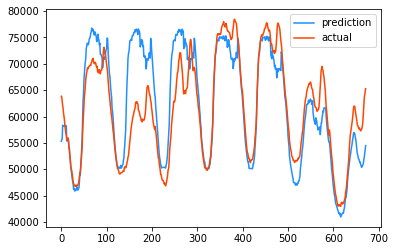

In [35]:
start = 48*56
num = 96*7
plt.plot(y_pred[start:num+start],label='prediction',color='dodgerblue')
plt.plot(y_test[start:num+start],label='actual',color='orangered')
plt.legend()
print('RMSE: '+ str(mean_squared_error(y_test, y_pred,squared=False)))
print('MAE: '+ str(mean_absolute_error(y_test,y_pred)))

In [175]:
def getDatasets(train_test_split=0.7,year='2017'):
    df = db.GetDAPrices().join(db.GetLoad()).join(db.GetWxSet('Temperature'))
    # df = df[['LoadVolume','DAPrice','Temperature']]
    df = df[['LoadVolume']]
    df = df.loc[year].interpolate(method='linear')
    df = cfnc.AppendTimeIndexes(df)
    df = df.drop(columns=['Hour'])

    for col in df.columns:
        scaler = MinMaxScaler()
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

    y = df.pop('LoadVolume').values
    X = df.values
    split = int(len(X)*train_test_split)
    X_train, X_test = X[0:split], X[split:]
    y_train, y_test = y[0:split], y[split:]
    return X_train,X_test,y_train,y_test

In [176]:
X_train,a,y_train,b = getDatasets(.99999,'2017')
c,X_test,d,y_test = getDatasets(0,'2018')
b,a,c,d = [],[],[],[]

In [182]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# config = tf.ConfigProto(device_count={"CPU": 8})
# keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

def build_model():
    model = keras.Sequential([
    layers.Dense(124, activation='relu', input_shape=[np.shape(X_train)[1]]),
    layers.Dense(124, activation='relu'),
    layers.Dense(96, activation='relu'),
    layers.Dense(96, activation='relu'),
    # layers.Dense(96, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [183]:
model = build_model()

In [188]:
EPOCHS = 100

history = model.fit(
    X_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)])

Train on 28027 samples, validate on 7007 samples
Epoch 1/100
28027/28027 [==============================] - 3s 117us/sample - loss: 0.0029 - mae: 0.0336 - mse: 0.0029 - val_loss: 0.0160 - val_mae: 0.0950 - val_mse: 0.0160
Epoch 2/100
28027/28027 [==============================] - 3s 114us/sample - loss: 0.0029 - mae: 0.0332 - mse: 0.0029 - val_loss: 0.0156 - val_mae: 0.0867 - val_mse: 0.0156
Epoch 3/100
28027/28027 [==============================] - 3s 113us/sample - loss: 0.0028 - mae: 0.0330 - mse: 0.0028 - val_loss: 0.0169 - val_mae: 0.0907 - val_mse: 0.0169
Epoch 4/100
28027/28027 [==============================] - 3s 111us/sample - loss: 0.0028 - mae: 0.0326 - mse: 0.0028 - val_loss: 0.0176 - val_mae: 0.0849 - val_mse: 0.0176
Epoch 5/100
28027/28027 [==============================] - 3s 107us/sample - loss: 0.0028 - mae: 0.0324 - mse: 0.0028 - val_loss: 0.0171 - val_mae: 0.0849 - val_mse: 0.0171
Epoch 6/100
28027/28027 [==============================] - 3s 110us/sample - loss: 0.0

In [189]:
y_pred = model.predict(X_test)

RMSE: 0.10766872892561116
MAE: 0.07445321927034426


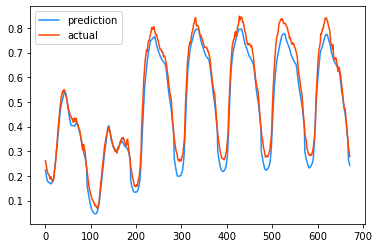

In [190]:
start = 48*360
num = 96*7
plt.plot(y_pred[start:num+start],label='prediction',color='dodgerblue')
plt.plot(y_test[start:num+start],label='actual',color='orangered')
plt.legend()
print('RMSE: '+ str(mean_squared_error(y_test, y_pred,squared=False)))
print('MAE: '+ str(mean_absolute_error(y_test,y_pred)))
print('R²: '+ str(r2_score(y_test,y_pred)))

In [191]:
model.save(db.__datapath)

INFO:tensorflow:Assets written to: c:\Users\henri\source\repos\mozubi_tools\_Data\PredictionDataBase\assets
